In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import warnings

warnings.filterwarnings("ignore", category=RuntimeWarning)
np.seterr(all='ignore')

cars = pd.read_parquet("cars_ready_LinearRegression_small.parquet")
desc_cols = [col for col in cars.columns if col.startswith("desc_pca_")]
print(f"Używane kolumny: {desc_cols[:5]} ... {desc_cols[-5:]}")

# Podział train/test
train_df = cars[cars["cv_fold"] != -1].copy()
test_df = cars[cars["cv_fold"] == -1].copy()

X_train = train_df[desc_cols].values
y_train = train_df["Log_Price"].values
X_test = test_df[desc_cols].values
y_test = test_df["Log_Price"].values



Używane kolumny: ['desc_pca_0', 'desc_pca_1', 'desc_pca_2', 'desc_pca_3', 'desc_pca_4'] ... ['desc_pca_45', 'desc_pca_46', 'desc_pca_47', 'desc_pca_48', 'desc_pca_49']


In [2]:
kf = KFold(n_splits=5, shuffle=True, random_state=42)
results = {"fold": [], "MAE": [], "RMSE": [], "R2": []}

for fold, (train_idx, val_idx) in enumerate(kf.split(X_train)):
    X_tr, X_val = X_train[train_idx], X_train[val_idx]
    y_tr, y_val = y_train[train_idx], y_train[val_idx]

    model = Ridge(alpha=1.0)
    model.fit(X_tr, y_tr)
    y_pred = model.predict(X_val)

    mae = mean_absolute_error(y_val, y_pred)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))  # bez "squared=False"
    r2 = r2_score(y_val, y_pred)

    results["fold"].append(fold)
    results["MAE"].append(mae)
    results["RMSE"].append(rmse)
    results["R2"].append(r2)

print("📊 CV Results:")
print(pd.DataFrame(results).mean(numeric_only=True).round(4))


final_model = Ridge(alpha=1.0)
final_model.fit(X_train, y_train)
y_pred_test = final_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2 = r2_score(y_test, y_pred_test)

print("📊 Test set performance (desc_pca only):")
print(f"MAE:  {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R²:   {r2:.4f}")

📊 CV Results:
fold    2.0000
MAE     0.5989
RMSE    0.7632
R2      0.3247
dtype: float64
📊 Test set performance (desc_pca only):
MAE:  0.5973
RMSE: 0.7598
R²:   0.3281


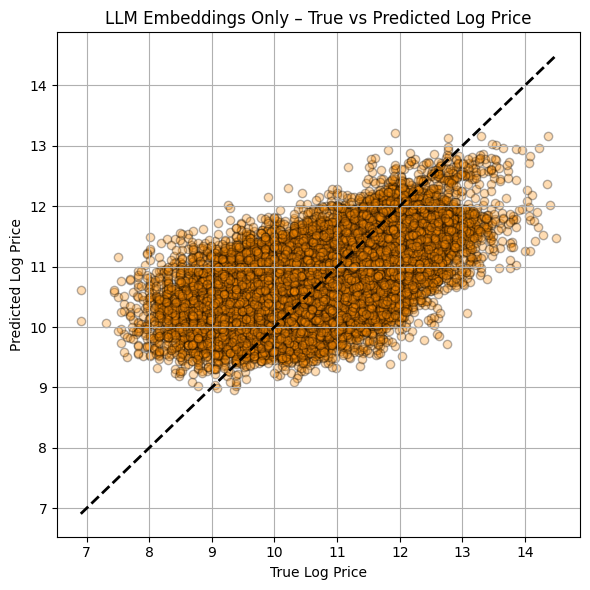

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_test, alpha=0.3, color="darkorange", edgecolor="k")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=2)
plt.xlabel("True Log Price")
plt.ylabel("Predicted Log Price")
plt.title("LLM Embeddings Only – True vs Predicted Log Price")
plt.grid(True)
plt.tight_layout()
plt.show()

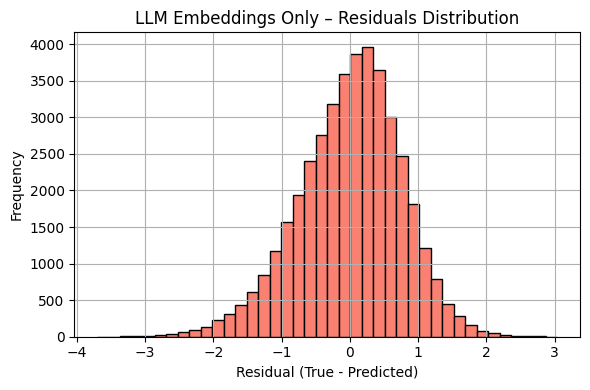

In [4]:
residuals = y_test - y_pred_test

plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, color='salmon', edgecolor='black')
plt.title("LLM Embeddings Only – Residuals Distribution")
plt.xlabel("Residual (True - Predicted)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()